In [1]:
%env KMP_DUPLICATE_LIB_OK=TRUE 
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from nfmd import NFMD
import pyhht
from utils import compute_hilbert

# Pull out common plotting settings:
from plot_params import get_plot_params
full_params, half_params = get_plot_params()
plt.rcParams.update(full_params)

env: KMP_DUPLICATE_LIB_OK=TRUE


In [2]:
# Generate an example signal
fs = 5000
t_max = 1
n = int(fs*t_max)

# Build signal
t = np.linspace(0,t_max,n)
dt = t[1]-t[0]


# Define a time-dependent phase function
f_base = 350
df_1 = 10
tau_1 = 0.5
omega_1 = lambda x: f_base + (df_1)*(1-np.exp(-x/tau_1))
amp_1 = lambda x: 1 + 0.5*np.exp(-x/3)


omega_2 = lambda x: 80-2*x
amp_2 = lambda x: 8 - 0.5*np.exp(-x)


mu = lambda x: 1.5 + 2.5*np.exp(-x/(1.5))
#mu = lambda x: 2*x-0.3*x**2
#mu = lambda t: (0.2)*np.sin(t)

# Create data with time-dependent frequency
z_1 = lambda t: amp_1(t)*np.cos(2*np.pi*omega_1(t)*t)
z_2 = lambda t: amp_2(t)*np.cos(2*np.pi*omega_2(t)*t) 

z = z_1(t) 
z += z_2(t)
z += mu(t)
#z = z/np.std(z)

In [3]:
%%time

###############
# Nonstationary Fourier Mode Decomposition
###############

nfmd = NFMD(z/np.std(z),
            num_freqs=3,
            window_size=250,
            optimizer=optim.SGD,
            #optimizer=optim.Adagrad,
            optimizer_opts={'lr': 1e-04},
            max_iters=100,
            target_loss=5e-4)

freqs, A, losses, indices = nfmd.decompose_signal(500)

n_freqs = nfmd.correct_frequencies(dt=dt)
n_amps = nfmd.compute_amps()
n_mean = nfmd.compute_mean()

0/4751|500/4751|1000/4751|1500/4751|2000/4751|2500/4751|3000/4751|3500/4751|4000/4751|4500/4751|Wall time: 2.78 s


In [4]:
%%time

###############
# Hilbert-Huang Transform
###############

emd = pyhht.emd.EMD(z, t)
imfs = emd.decompose()

imf_results = []
for imf in imfs:
    imf_results.append(compute_hilbert(imf, fs))
    
print(len(imf_results))
mean_imf = imfs[-1]

4
Wall time: 21 ms


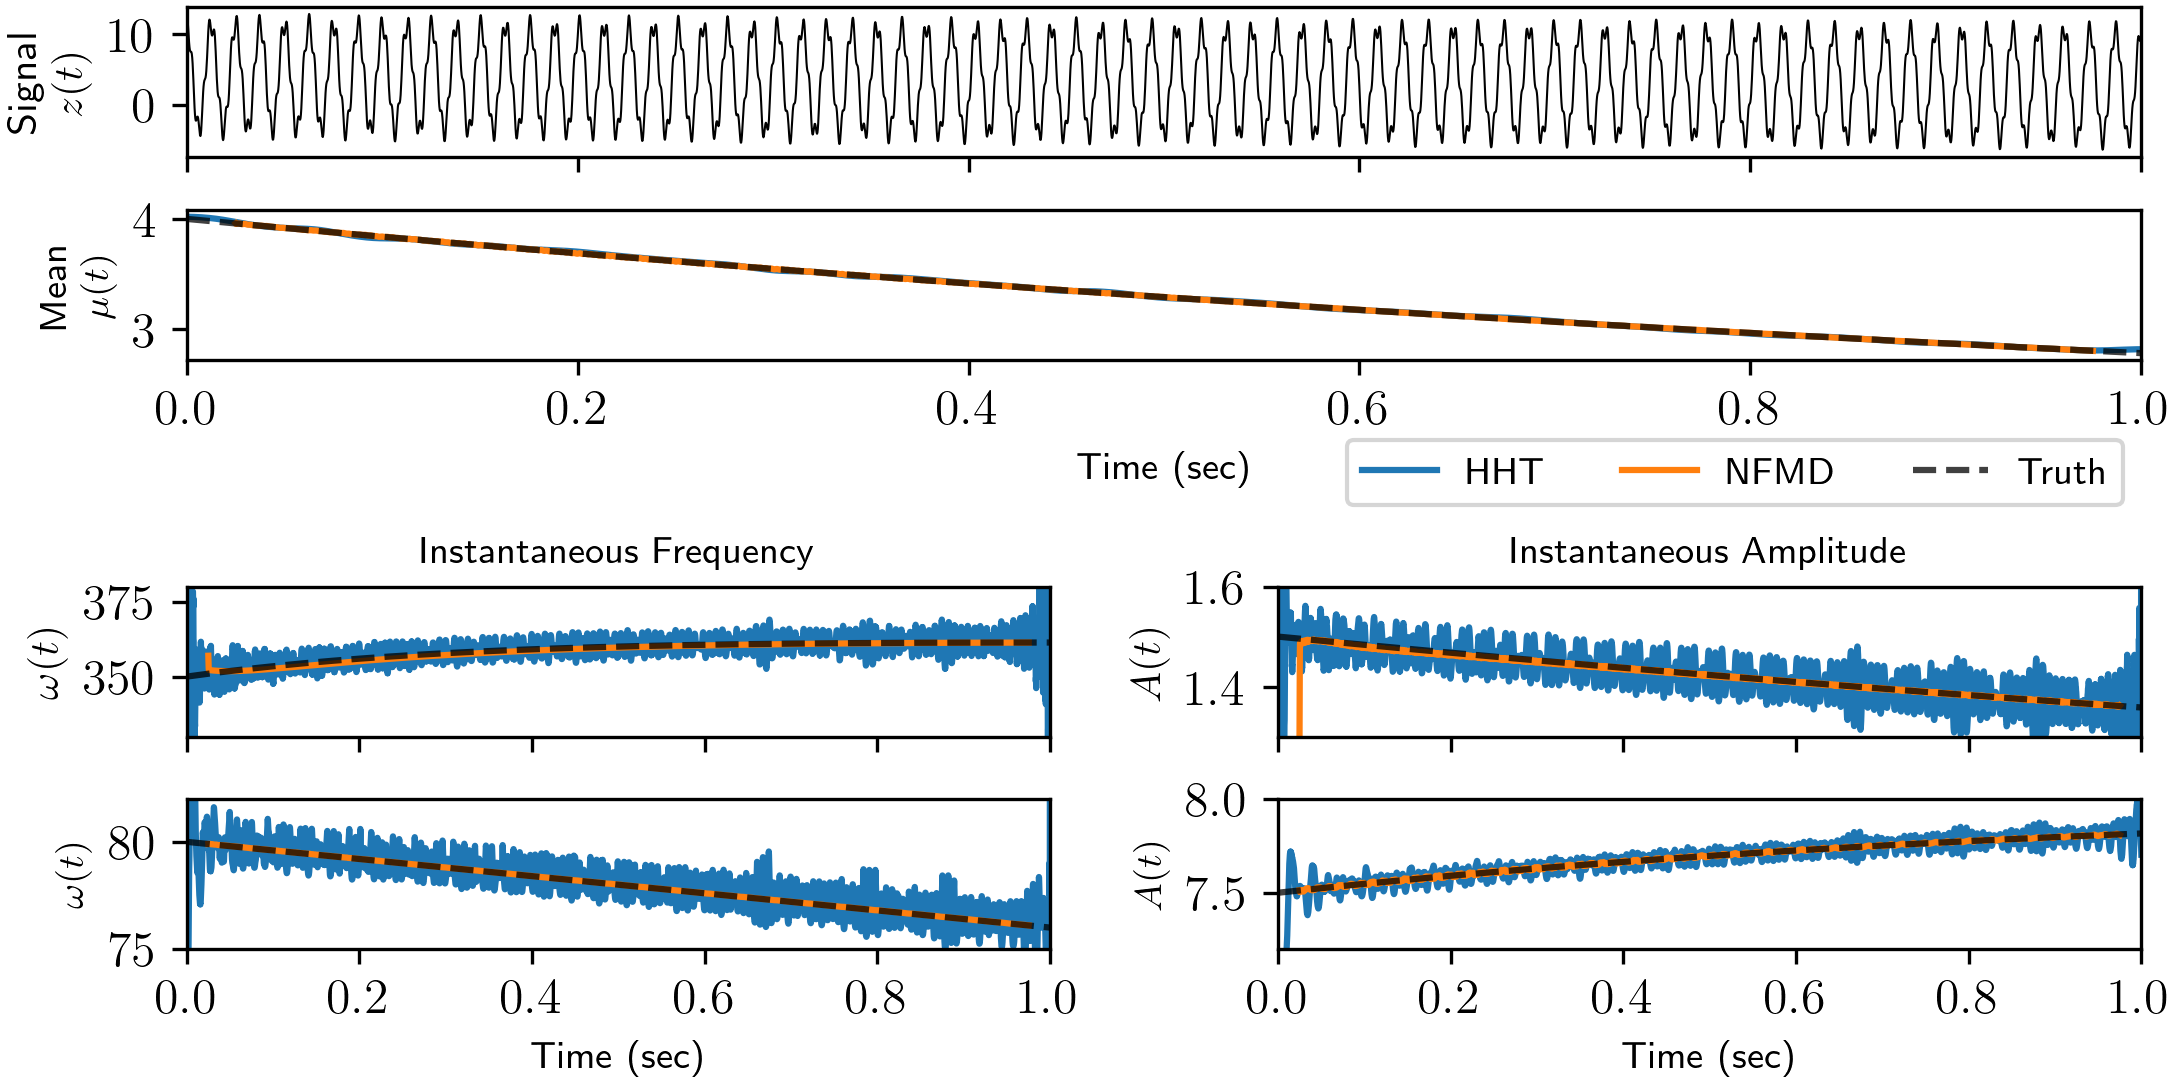

In [5]:
plt.rcParams.update(full_params)

fig3 = plt.figure(constrained_layout=True)
gs = fig3.add_gridspec(4, 2)

idcs = np.asarray(nfmd.mid_idcs)

#color = 'brown'

##############################################
## Axes List 1 -- Top Row -- Signal Example ##
##############################################
ax1 = fig3.add_subplot(gs[0, :])
ax1.plot(t, z, lw=0.5, color='k')
ax1.set_ylabel('Signal\n$z(t)$')

##########################################
## Second row -- Third Mode Comparisons ##
##########################################
ax2 = fig3.add_subplot(gs[1,:], sharex=ax1)

ax2.plot(t, mean_imf, label='HHT')
ax2.plot(t[nfmd.mid_idcs], n_mean*np.std(z), label='NFMD')#, color=color)
ax2.plot(t, mu(t), '--k', label='Truth', alpha=0.75)

ax2.legend(bbox_to_anchor=(1,-0.75), loc='right', ncol=3, fontsize=9)
ax2.set_ylabel('Mean\n$\mu(t)$', fontsize=9)
ax2.set_xlabel('Time (sec)', fontsize=9)
ax2.set_xlim([0,1])


# Set up lower axes
ax3a = fig3.add_subplot(gs[2,0])
ax3b = fig3.add_subplot(gs[2,1])
ax4a = fig3.add_subplot(gs[3,0], sharex=ax3a)
ax4b = fig3.add_subplot(gs[3,1], sharex=ax3b)

# Hide higher axis xlabels
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax3a.get_xticklabels(), visible=False)
plt.setp(ax3b.get_xticklabels(), visible=False)

# Put titles on the 3a and 3b columns
ax3a.set_title('Instantaneous Frequency', fontsize=9)
ax3b.set_title('Instantaneous Amplitude', fontsize=9)

######################################
## Axes 3 -- First Mode Comparisons ##
######################################
f_idx = 2
emd_idx = 0

# Plot the Instantaneous Frequencies
ax3a.plot(t, imf_results[emd_idx][1])
ax3a.plot(t[nfmd.mid_idcs], n_freqs[:,f_idx])#, color=color)
ax3a.plot(t, np.gradient(omega_1(t)*t, dt), '--k', alpha=0.75)

# And the instantaneous Amplitudes
ax3b.plot(t, imf_results[emd_idx][3])
ax3b.plot(t[nfmd.mid_idcs], n_amps[:,f_idx]*np.std(z))#, color=color)
ax3b.plot(t, amp_1(t), '--k', alpha=0.75)

# Format axes
ax3a.set_ylabel(r"$\omega(t)$")
ax3b.set_ylabel('$A(t)$')
ax3a.set_ylim([330,380])
ax3b.set_ylim([1.3,1.6])

##########################################
## Third row -- Second Mode Comparisons ##
##########################################
f_idx = 1
emd_idx = 1

ax4a.plot(t, imf_results[emd_idx][1])
ax4a.plot(t[nfmd.mid_idcs], n_freqs[:,f_idx])#, color=color)
ax4a.plot(t, np.gradient(omega_2(t)*t, dt), '--k', alpha=0.75)

ax4b.plot(t, imf_results[emd_idx][3])
ax4b.plot(t[nfmd.mid_idcs], n_amps[:,f_idx]*np.std(z))#, color=color)
ax4b.plot(t, amp_2(t), '--k', alpha=0.75)

# Format axes
ax4a.set_ylabel(r"$\omega(t)$", fontsize=9)
ax4b.set_ylabel('$A(t)$', fontsize=9)
ax4a.set_xlabel('Time (sec)', fontsize=9)
ax4b.set_xlabel('Time (sec)', fontsize=9)

ax4a.set_ylim([75,82])
ax4b.set_ylim([7.2,8])
ax4a.set_xlim([0,1])
ax4b.set_xlim([0,1])

# Final adjustments
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)

plt.savefig("Fig4.png")

plt.show()